In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import tree
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# download necessary resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read datasets

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

## Data cleaning and preparation

In [3]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [4]:
data.head(5)

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [5]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [6]:
data.head()

,title,text,subject,date,target
0,Spain's Deputy PM to deliver address at 2020 GMT,MADRID (Reuters) - Spain s deputy prime minist...,worldnews,"October 10, 2017",true
1,"French, Nigerien forces operating where three ...",NIAMEY (Reuters) - French and Nigerien troops ...,worldnews,"October 5, 2017",true
2,U.S. House panel issues subpoenas to Justice D...,WASHINGTON (Reuters) - The U.S. House Intellig...,politicsNews,"September 6, 2017",true
3,WATCH Tina Fey’s Triumphant Return To SNL As ...,Tina Fey once again took on Sarah Palin on Sat...,News,"January 24, 2016",fake
4,Cleveland officials to outline security for Re...,(Reuters) - The mayor and police chief of Clev...,politicsNews,"May 28, 2016",true


In [7]:
# Removing the date and title
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,MADRID (Reuters) - Spain s deputy prime minist...,worldnews,true
1,NIAMEY (Reuters) - French and Nigerien troops ...,worldnews,true
2,WASHINGTON (Reuters) - The U.S. House Intellig...,politicsNews,true
3,Tina Fey once again took on Sarah Palin on Sat...,News,fake
4,(Reuters) - The mayor and police chief of Clev...,politicsNews,true


In [8]:
# define a function to clean the text
def clean_text(text):
    # remove punctuations and numbers
    cleaned_text = ''.join(e for e in text if e.isalpha() or e.isspace())
    # convert to lowercase
    cleaned_text = cleaned_text.lower()
    # tokenize the text into words
    words = word_tokenize(cleaned_text)
    # remove stopwords
    stopword = stopwords.words('english')
    words = [word for word in words if word not in stopword]
    # stem the remaining words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # join the stemmed words back into a string
    cleaned_text = ' '.join(words)
    # print(cleaned_text)
    return cleaned_text

# Clean data
data = data.dropna()
data["text"] = data["text"].apply(clean_text)


## Modeling

In [9]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
y_pred  = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, y_pred )*100,2)))

accuracy: 99.58%


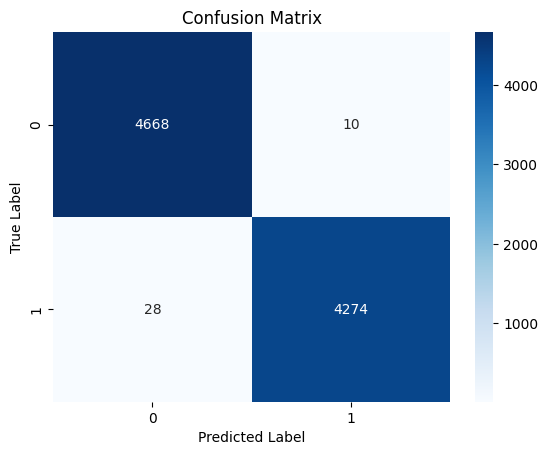

In [11]:
from sklearn.metrics import confusion_matrix

# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
# Predict probabilities for each class
proba = model.predict_proba([X_test.values[3]])

# Predict labels for test set
prediction = model.predict([X_test.values[3]])

# Display predicted class labels along with predicted probabilities
for i, class_label in enumerate(model.classes_):
    print("Class '{}' - Probability = {:.2f}%".format(class_label, proba[0][i]*100))
print("Predicted class = {}".format(prediction[0]))


Class 'fake' - Probability = 0.00%
Class 'true' - Probability = 100.00%
Predicted class = true


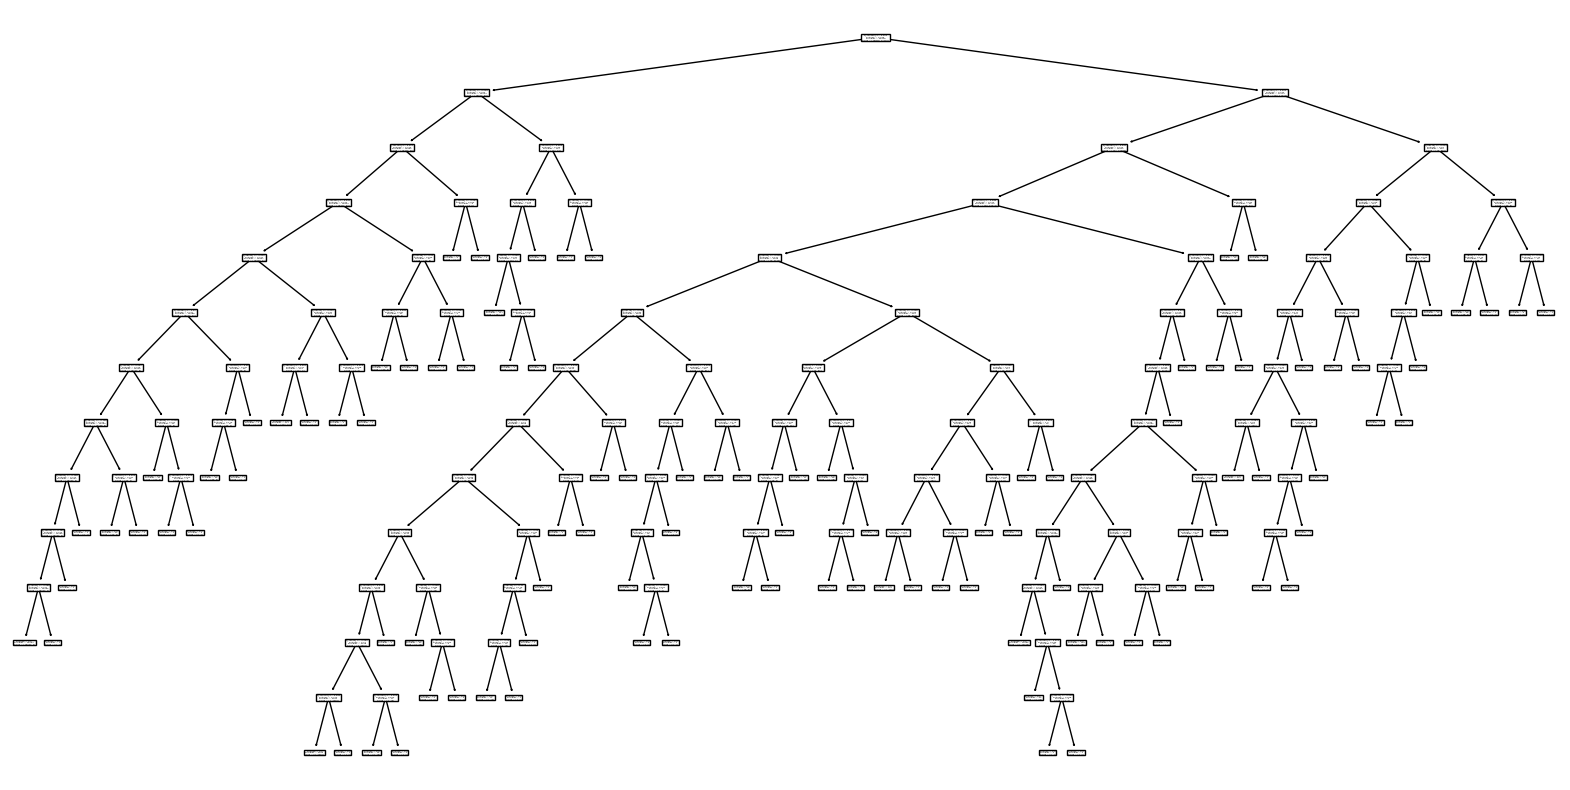

In [13]:
# Extract the decision tree from the pipeline
tree_model = model.named_steps['model']

# Visualize the decision tree
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(tree_model, ax=ax)

# Save the image with higher dpi
fig.savefig('decision_tree.png', dpi=1000)

# Show the image
plt.show()
